This notebook is for exploratory analysis of COVID-19 Radiography database from Kaggle : https://www.kaggle.com/tawsifurrahman/covid19-radiography-datab
ase


In [ ]:
import os
import random
from collections import defaultdict
from glob import glob
from math import pi
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from joblib import Parallel, delayed
from skimage.feature import graycomatrix, graycoprops
from tqdm.auto import tqdm
from IPython.display import HTML, display

# CHEMINS ET CHARGEMENT DES DONNEES

## CHEMINS

In [ ]:
# @title VARIABLES DE SESSION
# @markdown
DATA_ROOT = "../data"  # @param {type: "string"}
# @markdown ---

In [ ]:
DATA_ROOT = Path(DATA_ROOT)
RAW_DATA = DATA_ROOT / "01_raw/COVID-19_Radiography_Dataset"
REPS = ["COVID", "Lung_Opacity", "Viral Pneumonia", "Normal"]

In [ ]:
# TODO (Done): taille des images, canaux, nombre,
# TODO (All): Tester l'environnement de travail
# TODO (Yeyecodes): Appliquer les masques et refaire haraclick, moyenne des pixels,
# TODO (Yeyecodes & CedrickArmel): interprétation Haralickpuis
# TODO (TaxelleT & CedrickArmel): calculer l'aire des poumons. Gauche versus droite
# TODO (CedrickArmel): Explorer si la maladie ne concerne qu'une seule partie du poumon.
# TODO (CedrickArmel): équilibrer les classes, normaliser , rétirer les outlines, mettre les masques,
# TODO (TaxelleT & CedrickArmel): Appliquer pour mettre en évidence les files, cables

# TODO: data augmentation pour gérer les conditions de prise de vue
# TODO: Appliquer pour mettre en évidence les files, cables

## CHARGEMENT DES DONNES

In [ ]:
images = defaultdict()

In [ ]:
clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(32, 32))

In [ ]:
for rep in REPS:
    images[rep.lower().replace(" ", "_")] = [
        clahe.apply(cv2.imread(f, cv2.IMREAD_GRAYSCALE))
        for f in glob(str(RAW_DATA / rep / "images/*.png"))
    ]

## CALCUL DES CARACTERISTIQUES DE HARALICK

In [ ]:
def single_image_haralick(
    img: np.array, features: list, distances: list[int], angles: np.array
) -> dict[str, np.array]:
    """Computes a set of Haralick features for a single image."""
    glcm = graycomatrix(
        img, distances=distances, angles=angles, symmetric=True, normed=True
    )  # calcul de la GLCM
    result = {}
    for ft in features:
        props = graycoprops(glcm, prop=ft)  # Calcul des statistiques de Haralick
        result[ft] = props
    return result

In [ ]:
def compute_haralick_parallel(
    images: list[np.ndarray],
    features: list,
    distances: list[int],
    angles: np.array,
    n_jobs: int = -1,
    verbose=1,
) -> list[dict]:
    """Computes a set of Haralick features for a set of images in parallel using joblib."""
    results = Parallel(n_jobs=n_jobs, verbose=verbose)(
        delayed(single_image_haralick)(img, features, distances, angles)
        for img in images
    )
    return results

In [ ]:
DMAX = 29
HARALICK_FEATURES = [
    "mean",
    "std",
    "entropy",
    "contrast",
    "homogeneity",
    "energy",
    "correlation",
]
ANGLES = (np.pi / 4) * np.arange(0, 4)  # angles in rad from 0 to pi
DIRECTIONS = {"horizontal": 0, "diagonal1": 1, "vertical": 2, "diagonal2": 3}

In [ ]:
haralick_features = defaultdict(lambda: defaultdict(lambda: np.empty((DMAX, 0))))

```python
for rep, pool in tqdm(images.items()):
  results = compute_haralick_parallel(pool, HARALICK_FEATURES, range(DMAX), ANGLES)
  for r in results:
    for ft in HARALICK_FEATURES:
      haralick_features[ft][rep] = np.concat([haralick_features[ft][rep], r[ft]], axis=1)
```

```python
for rep in images.keys():
  for ft in HARALICK_FEATURES:
    np.save(file=DATA_ROOT/f"00_dumps/haralick_features_{ft}_{rep}_img_ctrst.npy", arr=haralick_features[ft][rep], allow_pickle=False)
```

Ci-dessous nous important directement les données précalculées (voir `Markdown`ci-dessus) de textures depuis le dossier Drive du projet.

In [ ]:
for rep in images.keys():
    for ft in HARALICK_FEATURES:
        haralick_features[ft][rep] = np.load(
            DATA_ROOT / f"00_dumps/haralick_features_{ft}_{rep}_img_ctrst.npy"
        )

## VISUALIZATION ET ANALYSE

### VISUALIZATION

In [ ]:
def display_haralick(
    d: str,
    directions: dict[str, int],
    haralick_features: dict[str, dict],
    ncols: int = 2,
):
    nrows = np.ceil(len(haralick_features) / ncols).astype(int)
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 4))
    axes = axes.flatten()
    for i, ft in enumerate(haralick_features):
        for rep in haralick_features[ft].keys():
            axes[i].plot(
                np.mean(haralick_features[ft][rep][:, directions[d] :: 4], axis=1),
                label=f"{rep.upper()}",
            )
        axes[i].set_title(ft.capitalize())
        # axes[i].legend(title="Health Status")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Health Status",
        loc="center right",
        bbox_to_anchor=(0.98, 0.3),
    )
    fig.suptitle(
        f"Caractéristique de Haralick selon la direction {d.capitalize() if 'diagonal' not in d else 'Diagonal'} - {directions[d] * 45}°",
        fontsize=16,
    )
    fig.supxlabel("Distance entre $x$ et $y$", fontsize=14)
    fig.supylabel("Valeur des caractéristiques", fontsize=14, x=0)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.tight_layout()
    plt.show()

In [ ]:
def display_texture_sample(
    name: str,
    texture: np.ndarray,
    features: dict[str, dict],
    d: str,
    directions: dict[str, int],
    ncols: int = 2,
):
    nrows = np.ceil((len(features) + 1) / ncols).astype(int)
    fig, axes = plt.subplots(nrows, 4, figsize=(20, nrows * 4))
    axes = axes.flatten()
    axes[0].imshow(texture, cmap="gray")
    axes[0].set_title("Texture")
    axes[0].axis("off")
    for i, ft in enumerate(features):
        axes[i + 1].plot(features[ft][:, directions[d] :: 4])
        axes[i + 1].set_title(ft.capitalize())

    for j in range(i + 2, len(axes)):
        axes[j].axis("off")

    fig.suptitle(
        f"Carac. de Haralick de la texture {name} - Direction {d.capitalize() if 'diagonal' not in d else 'Diagonal'} - {directions[d] * 45}°",
        fontsize=16,
    )

    fig.supxlabel("Distance entre $x$ et $y$", fontsize=14)
    fig.supylabel("Valeur des caractéristiques", fontsize=14, x=0)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.tight_layout()
    plt.show()

In [ ]:
def boxplot_all_haralick(haralick_features: dict[str, dict[str, np.ndarray]]) -> None:
    """Plots the computed Haralick's features box-plots.

    Args:
        haralick_features (dict[str, dict[str, np.ndarray]]): Haralick's features for all images.
    """
    features = list(haralick_features.keys())
    categories = list(next(iter(haralick_features.values())).keys())

    data_list = []
    for ft in features:
        for rep in categories:
            values = np.mean(haralick_features[ft][rep], axis=0)
            for v in values:
                data_list.append(
                    {"Feature": ft.capitalize(), "Category": rep.upper(), "Value": v}
                )

    df_plot = pd.DataFrame(data_list)

    plt.figure(figsize=(18, 6))
    sns.boxplot(x="Feature", y="Value", hue="Category", data=df_plot)
    plt.title("Distribution des features Haralick par catégorie")
    plt.ylabel("Valeur moyenne de la feature")
    plt.xlabel("Feature")
    plt.xticks(rotation=45)
    plt.legend(title="Catégorie")
    plt.tight_layout()
    plt.show()

In [ ]:
def heatmap_haralick_all(haralick_features: dict[str, dict[str, np.ndarray]]) -> None:
    """Plots the computed Haralick's features correlation heatmap.

    Args:
        haralick_features (dict[str, dict[str, np.ndarray]]): Haralick's features for all images.
    """
    for rep in next(iter(haralick_features.values())).keys():
        df = pd.DataFrame(
            {
                ft: np.mean(haralick_features[ft][rep], axis=0)
                for ft in haralick_features
            }
        )
        corr = df.corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f", square=True
        )
        plt.title(
            f"Corrélation entre features Haralick – {' '.join(rep.split('_')).upper()}"
        )
        plt.tight_layout()
        plt.show()

In [ ]:
def radar_all_haralick(haralick_features: dict[str, dict[str, np.ndarray]]) -> None:
    """Plots the computed Haralick's features radar.

    Args:
        haralick_features (dict[str, dict[str, np.ndarray]]): Haralick's features for all images.
    """
    features = list(haralick_features.keys())
    reps = haralick_features[features[0]].keys()

    N = len(features)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    for rep in reps:
        values = [np.mean(haralick_features[ft][rep]) for ft in features]
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=" ".join(rep.split("_")).upper())
        ax.fill(angles, values, alpha=0.15)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=11)
    ax.set_title("Radar chart – Signatures des textures Haralick", fontsize=11)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.show()

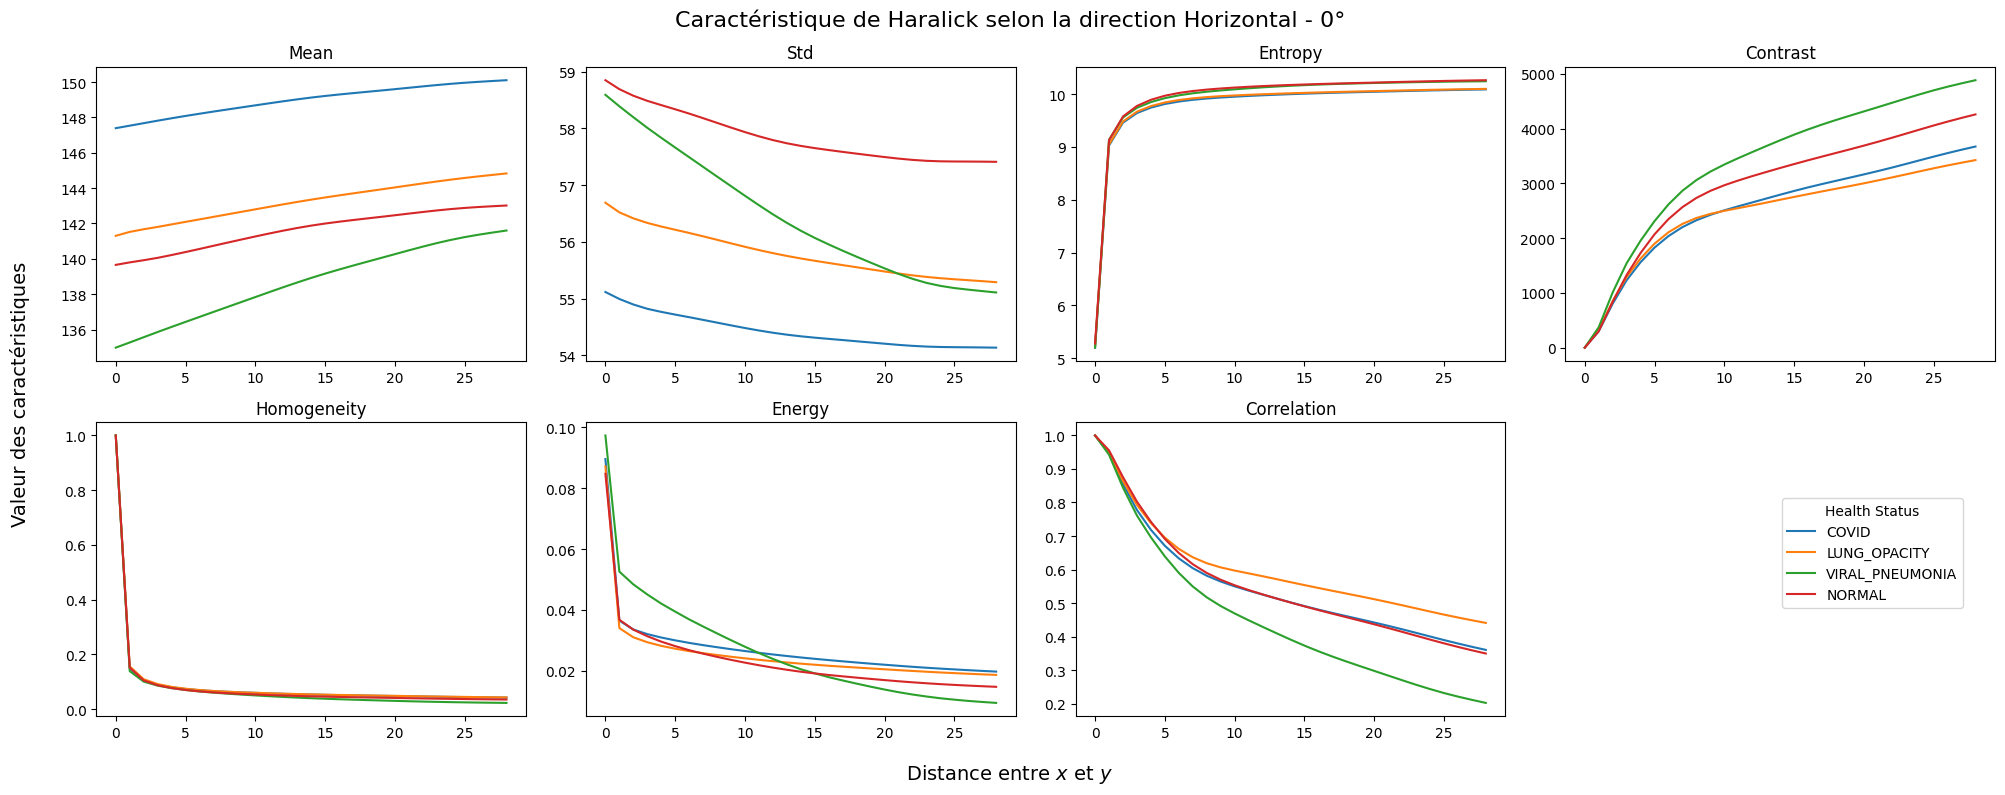

In [ ]:
display_haralick(
    d="horizontal", directions=DIRECTIONS, haralick_features=haralick_features, ncols=4
)

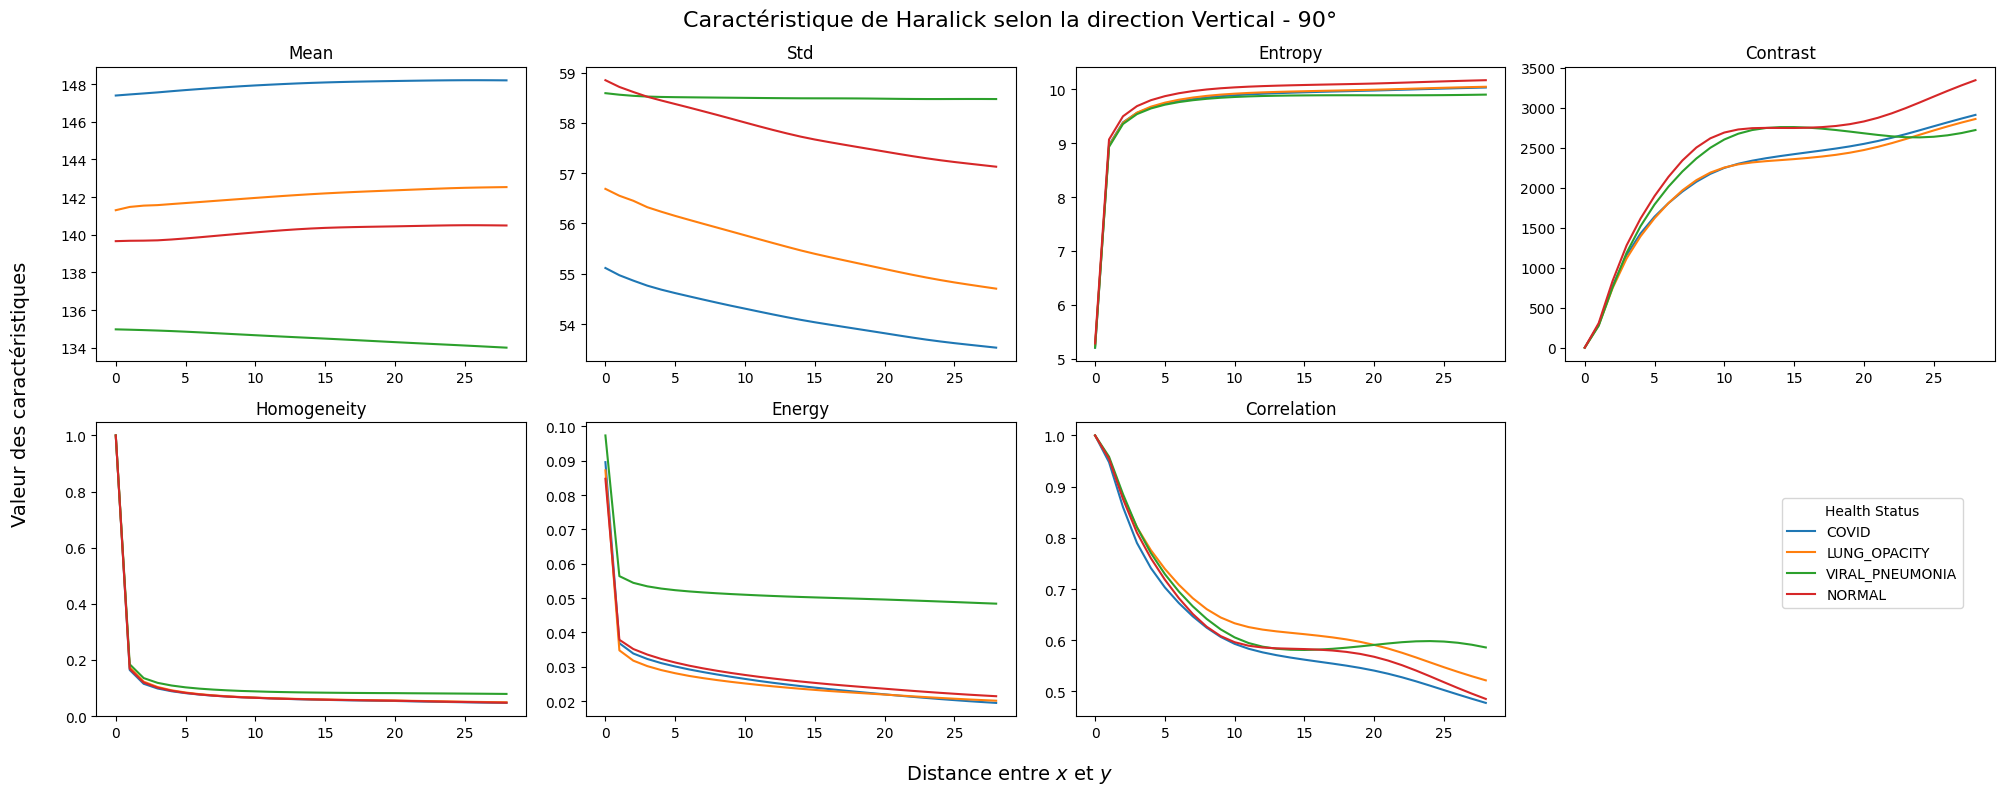

In [ ]:
display_haralick(
    d="vertical", directions=DIRECTIONS, haralick_features=haralick_features, ncols=4
)

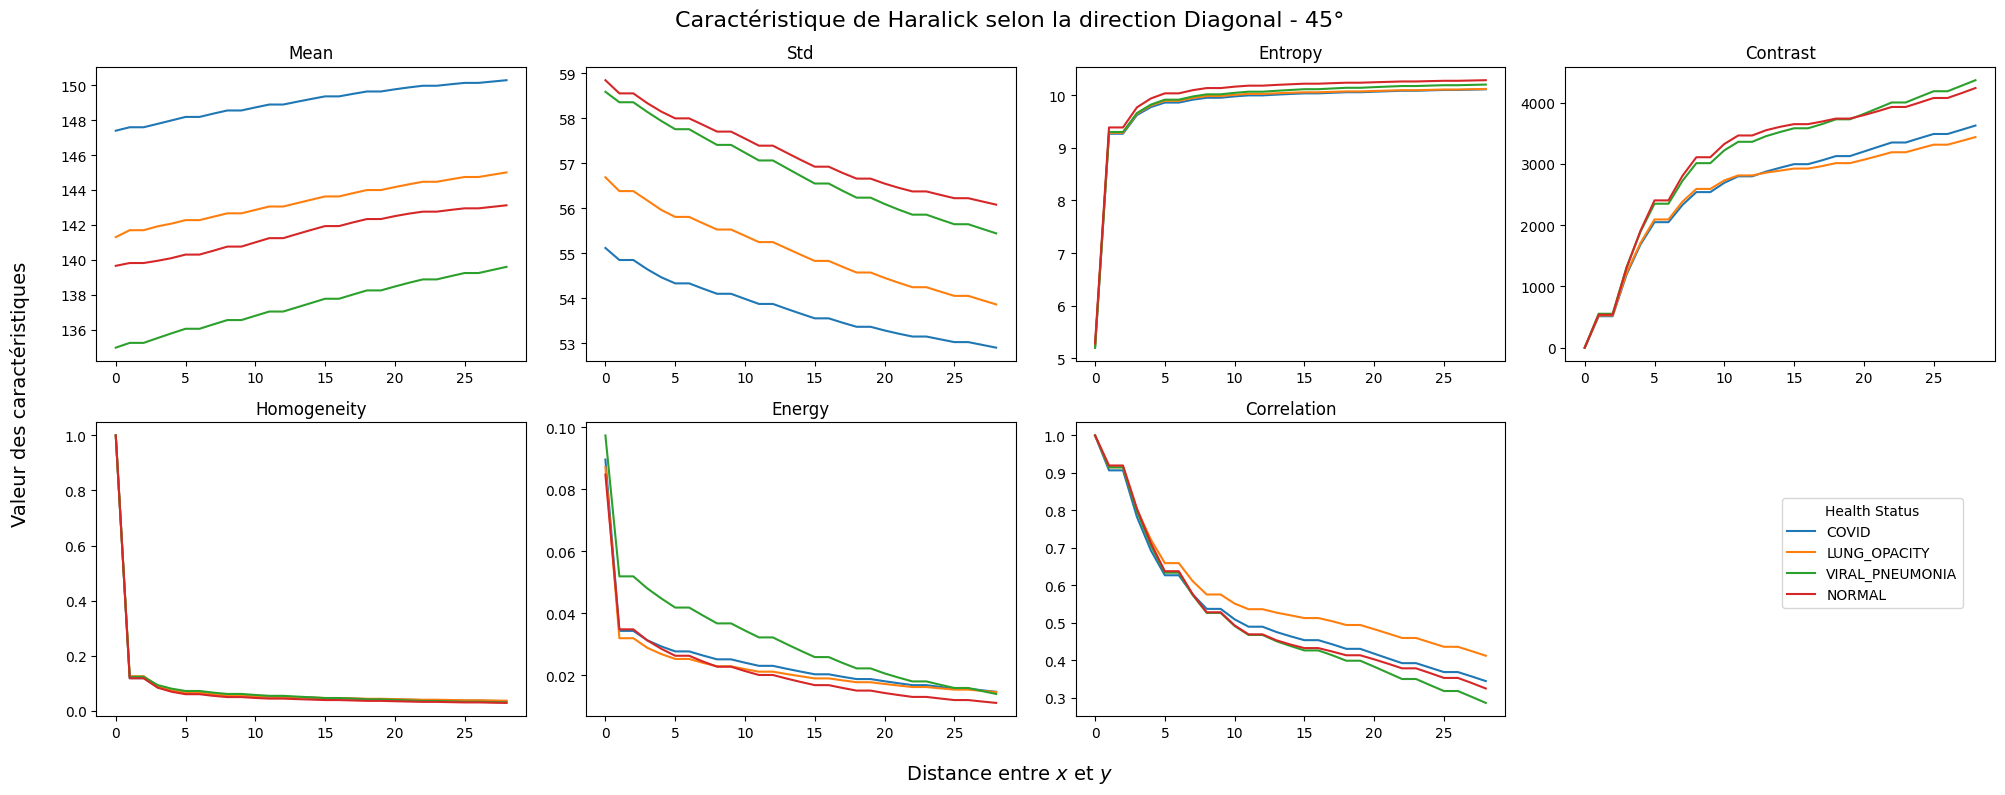

In [ ]:
display_haralick(
    d="diagonal1", directions=DIRECTIONS, haralick_features=haralick_features, ncols=4
)

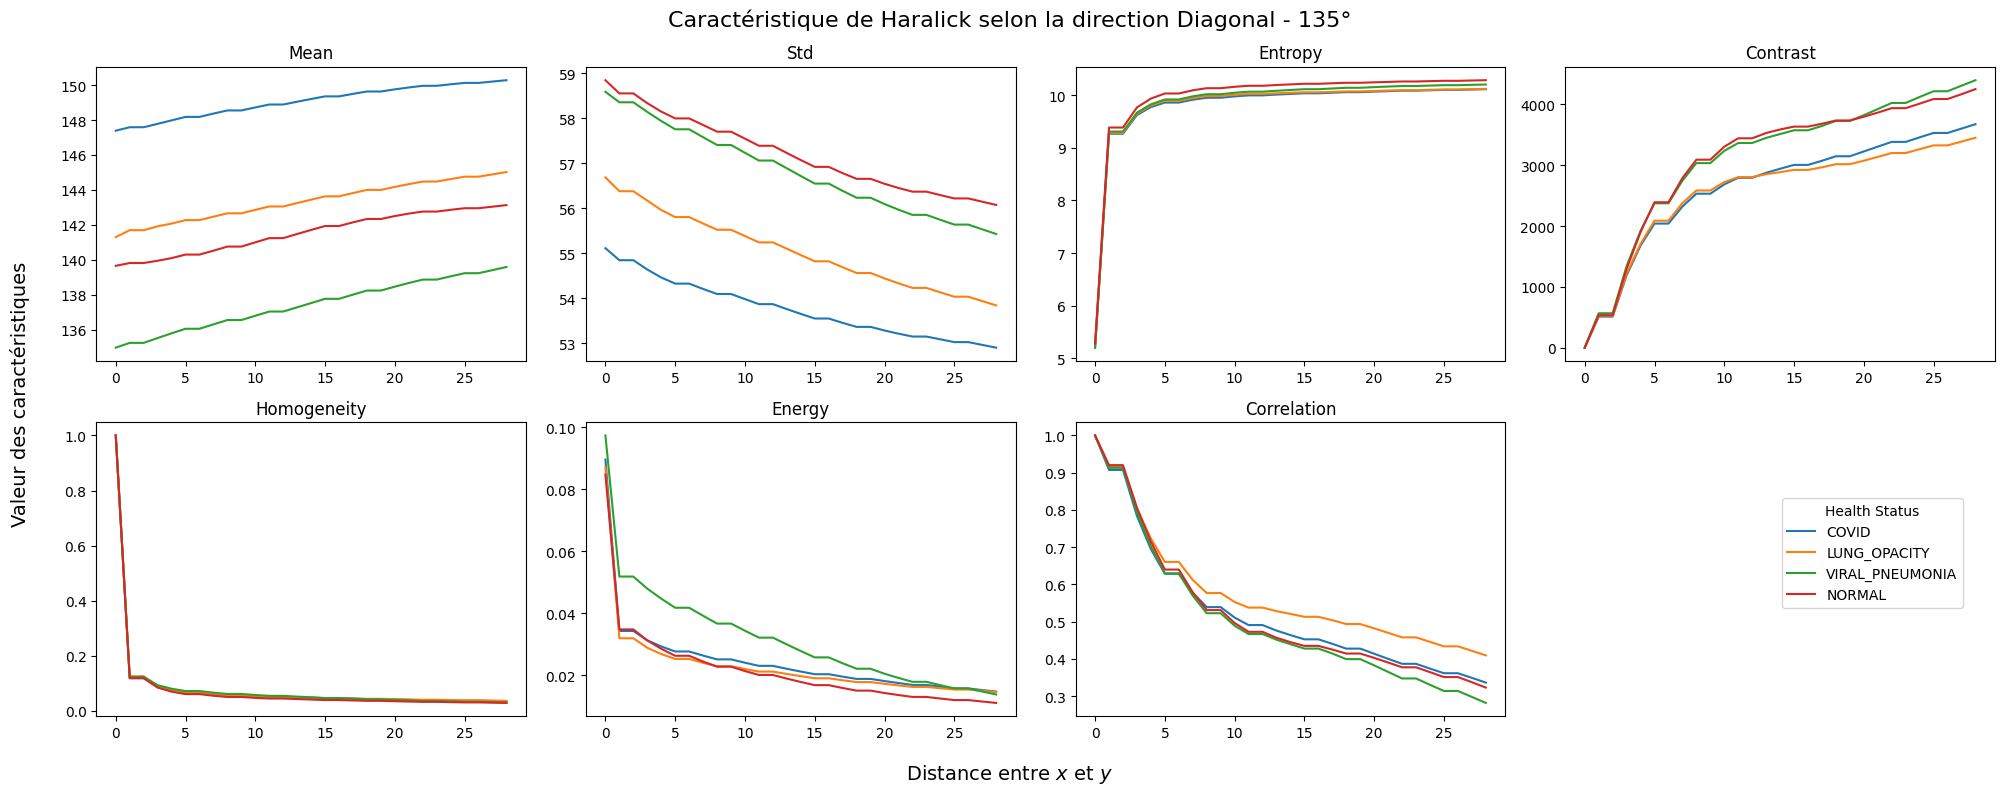

In [ ]:
display_haralick(
    d="diagonal2", directions=DIRECTIONS, haralick_features=haralick_features, ncols=4
)

L'augmentation du contraste des images pas eu d'impact sur les valeurs d'énergie. On peut en déduire que cette transformation n'a pas dégadé l'information contenu dans les images ainsi que les structures: L'augmentation du contrast révèle plus clairement les microtextures.

Les valeurs de niveuax de gris dans les images sont plus cohérents avec les niveaux de gris et l'opacité observée.

# CONCLUSIONS

- Inclure une augmentation du contraste dans la data augmentation
- ZOOM IN/OUT
- Normalisation des images
- utiliser les features non corrélés dans une classification XGBOOST comme baseline
- 

# REFRENCES



1.   Haralick, RM.; Shanmugam, K., “Textural features for image classification” IEEE Transactions on systems, man, and cybernetics 6 (1973): 610-621. [DOI:10.1109/TSMC.1973.4309314](https://doi.org/10.1109/TSMC.1973.4309314)
2.   

